In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF5DIZ0/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteF5DIZ0/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [4]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [5]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

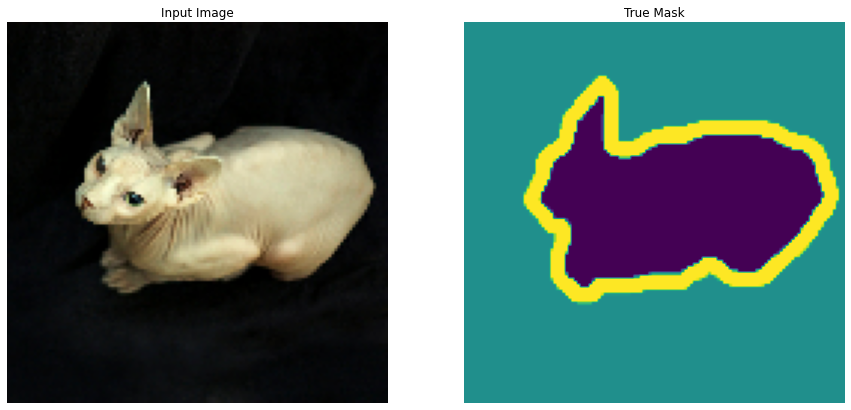

In [7]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [14]:
import os
import numpy as np
import pandas as pd
import cv2

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [15]:
def TL_unet_model(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_


# # Function for fine-tuning the model (unfreeze all layers) 
# def finetune_unfreezeall(input_shape, base_model):
#     input_shape = input_shape
#     base_model = base_model
    
#     # unfreeze the contracting path and freeze the expanding path
#     for layer in base_model.layers:
#         if layer.name in ['block1_conv1', 'block1_conv2', 'block1_pool',
#                           'block2_conv1', 'block2_conv2', 'block2_pool', 
#                           'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool',
#                           'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool',
#                           'block5_conv1', 'block5_conv2', 'block5_conv3']:
#             layer.trainable = True
            
#     return base_model    


# # [Failed] Approach 2: Adding Batch Normalization layer after each conv
# def BN_pretrained(input_shape):
#     # input: input_shape (height, width, channels) 
#     # return model
#     input_shape = input_shape
#     base_VGG = VGG16(include_top = False, 
#                    weights = "imagenet", 
#                    input_shape = input_shape)

#     # Building the encoder
#     inp = base_VGG.input
#     conv1 = base_VGG.get_layer(name='block1_conv1')(inp)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = base_VGG.get_layer(name='block1_conv2')(conv1)
#     conv1 = BatchNormalization()(conv1)
#     conv1 = base_VGG.get_layer(name='block1_pool')(conv1)
    
#     conv2 = base_VGG.get_layer(name='block2_conv1')(conv1)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = base_VGG.get_layer(name='block2_conv2')(conv2)
#     conv2 = BatchNormalization()(conv2)
#     conv2 = base_VGG.get_layer(name='block2_pool')(conv2)
    
#     conv3 = base_VGG.get_layer(name='block3_conv1')(conv2)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = base_VGG.get_layer(name='block3_conv2')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     comv3 = base_VGG.get_layer(name='block3_conv3')(conv3)
#     conv3 = BatchNormalization()(conv3)
#     conv3 = base_VGG.get_layer(name='block3_pool')(conv2)

#     conv4 = base_VGG.get_layer(name='block4_conv1')(conv3)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = base_VGG.get_layer(name='block4_conv2')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = base_VGG.get_layer(name='block4_conv3')(conv4)
#     conv4 = BatchNormalization()(conv4)
#     conv4 = base_VGG.get_layer(name='block4_pool')(conv4)
    
#     conv5 = base_VGG.get_layer(name='block5_conv1')(conv4)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = base_VGG.get_layer(name='block5_conv2')(conv5)
#     conv5 = BatchNormalization()(conv5)
#     conv5 = base_VGG.get_layer(name='block5_conv3')(conv5)
#     conv5 = BatchNormalization()(conv5)

#     # freezing all layers in VGG16 
#     for layer in base_VGG.layers: 
#         layer.trainable = False

#     # the bridge (exclude the last maxpooling layer in VGG16) 
#     bridge = base_VGG.get_layer("block5_conv3").output
#     print(bridge.shape)
    
    
#     # Decoder now
#     up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
#     print(up1.shape)
#     up1 = BatchNormalization()(up1)
    
#     concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
#     conv6 = BatchNormalization()(conv6)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
#     conv6 = BatchNormalization()(conv6)

#     up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
#     print(up2.shape)
#     up2 = BatchNormalization()(up2)
    
#     concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
#     conv7 = BatchNormalization()(conv7)

#     up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
#     print(up3.shape)
#     up3 = BatchNormalization()(up3)
    
#     concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
#     conv8 = BatchNormalization()(conv8)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
#     conv8 = BatchNormalization()(conv8)

#     up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
#     print(up4.shape)
#     up4 = BatchNormalization()(up4)
    
#     concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
#     conv9 = BatchNormalization()(conv9)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
#     conv9 = BatchNormalization()(conv9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     print(conv10.shape)

#     model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

#     return model_



# # Model version 3 Cross domain pre-train with large XPIE dataset
# # this is the U-Net model structure 
# def unet_model_v3(input_shape):
    
#     inp = Input(input_shape)
    
#     # contracting path 
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
#     conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#     # Expanding path 
#     up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
#     print(up1.shape)
    
#     concat_1 = concatenate([up1, conv4], axis=3)
    
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
#     conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

#     up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
#     print(up2.shape)
    
#     concat_2 = concatenate([up2, conv3], axis=3)
    
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
#     conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

#     up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
#     print(up3.shape)
    
#     concat_3 = concatenate([up3, conv2], axis=3)
    
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
#     conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

#     up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
#     print(up4.shape)
    
#     concat_4 = concatenate([up4, conv1], axis=3)
    
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
#     conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
#     print(conv10.shape)

#     model_ = Model(inputs=[inp], outputs=[conv10])
    
#     return model_

In [16]:
model = TL_unet_model([128, 128, 3])
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
(None, 8, 8, 512)
(None, 16, 16, 512)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 64)
(None, 128, 128, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_c

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [18]:
import os
print(tf.version.VERSION)
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights


2.11.0


Epoch 1/20
1/1 [==============================] - 1s 1s/step


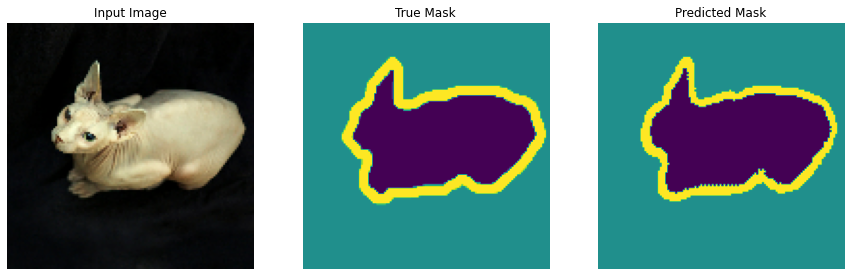


Sample Prediction after epoch 1

920/920 [==============================] - 80s 62ms/step - loss: 0.4135 - accuracy: 0.8352 - val_loss: 0.3431 - val_accuracy: 0.8668
Epoch 2/20
1/1 [==============================] - 0s 21ms/step


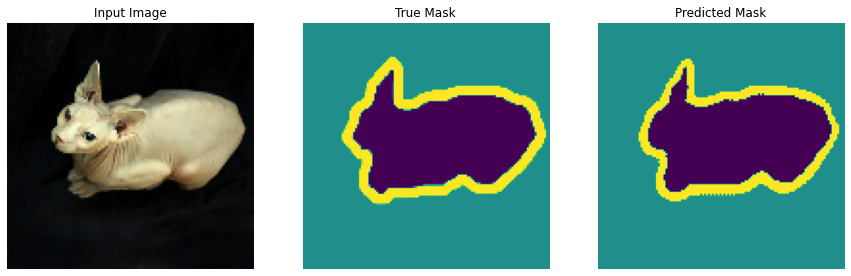


Sample Prediction after epoch 2

920/920 [==============================] - 55s 59ms/step - loss: 0.3075 - accuracy: 0.8764 - val_loss: 0.3361 - val_accuracy: 0.8738
Epoch 3/20
1/1 [==============================] - 0s 21ms/step


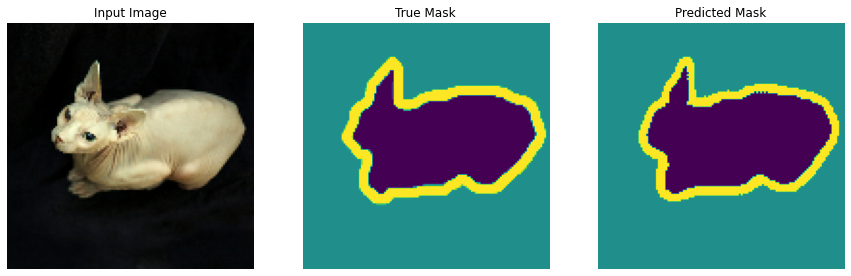


Sample Prediction after epoch 3

920/920 [==============================] - 54s 58ms/step - loss: 0.2845 - accuracy: 0.8849 - val_loss: 0.3147 - val_accuracy: 0.8750
Epoch 4/20
1/1 [==============================] - 0s 25ms/step


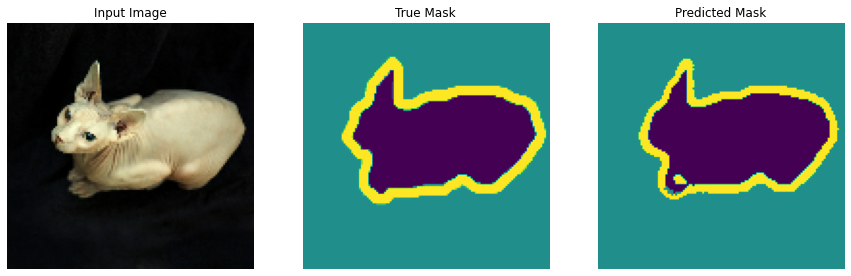


Sample Prediction after epoch 4

920/920 [==============================] - 54s 59ms/step - loss: 0.2581 - accuracy: 0.8940 - val_loss: 0.3143 - val_accuracy: 0.8795
Epoch 5/20
1/1 [==============================] - 0s 22ms/step


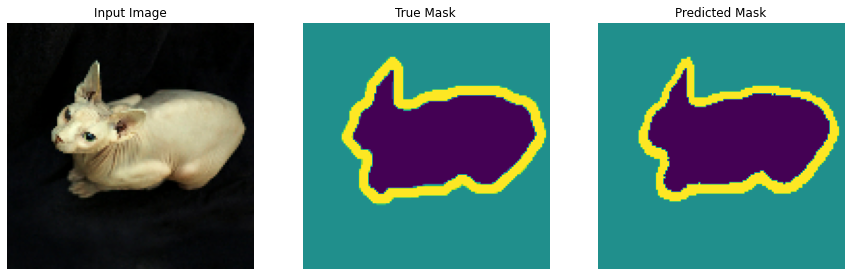


Sample Prediction after epoch 5

920/920 [==============================] - 55s 60ms/step - loss: 0.2379 - accuracy: 0.9013 - val_loss: 0.3209 - val_accuracy: 0.8832
Epoch 6/20
1/1 [==============================] - 0s 25ms/step


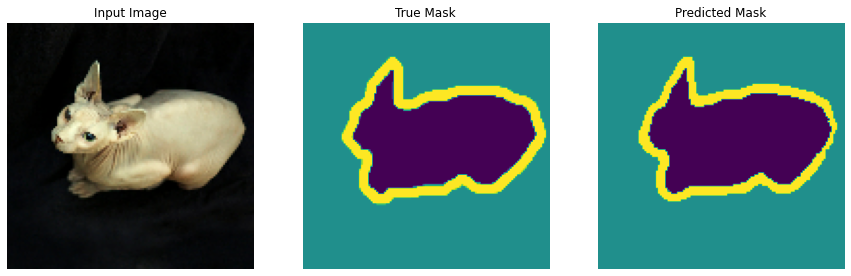


Sample Prediction after epoch 6

920/920 [==============================] - 54s 59ms/step - loss: 0.2222 - accuracy: 0.9070 - val_loss: 0.3080 - val_accuracy: 0.8844
Epoch 7/20
1/1 [==============================] - 0s 23ms/step


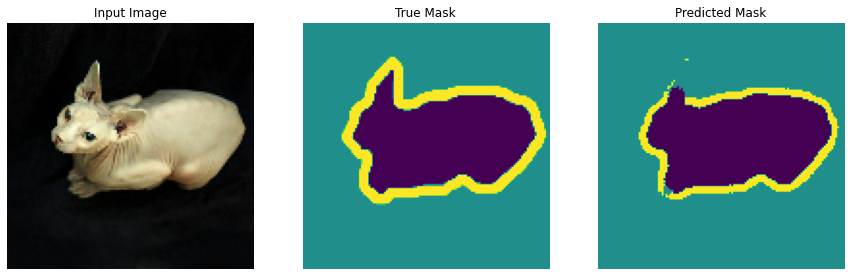


Sample Prediction after epoch 7

920/920 [==============================] - 54s 59ms/step - loss: 0.2171 - accuracy: 0.9092 - val_loss: 0.3271 - val_accuracy: 0.8788
Epoch 8/20
1/1 [==============================] - 0s 25ms/step


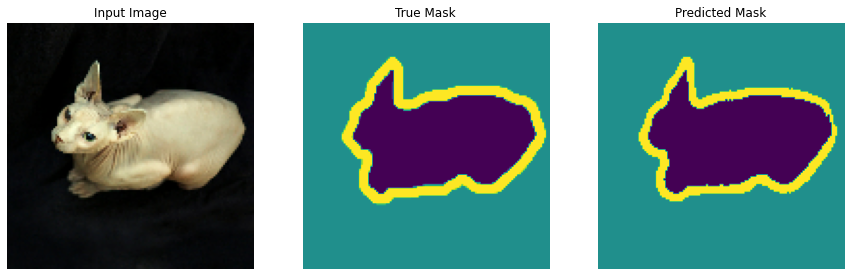


Sample Prediction after epoch 8

920/920 [==============================] - 54s 59ms/step - loss: 0.1992 - accuracy: 0.9151 - val_loss: 0.3095 - val_accuracy: 0.8840
Epoch 9/20
1/1 [==============================] - 0s 22ms/step


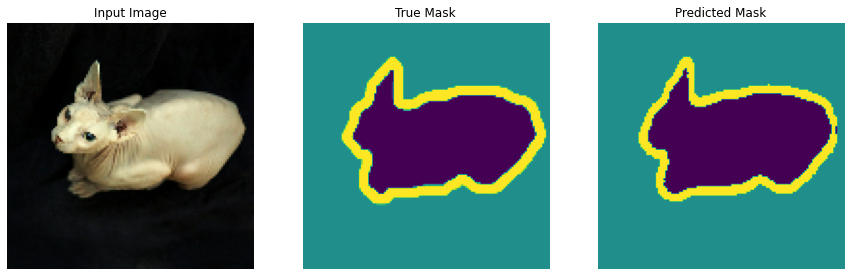


Sample Prediction after epoch 9

920/920 [==============================] - 54s 59ms/step - loss: 0.1905 - accuracy: 0.9182 - val_loss: 0.3277 - val_accuracy: 0.8868
Epoch 10/20
1/1 [==============================] - 0s 22ms/step


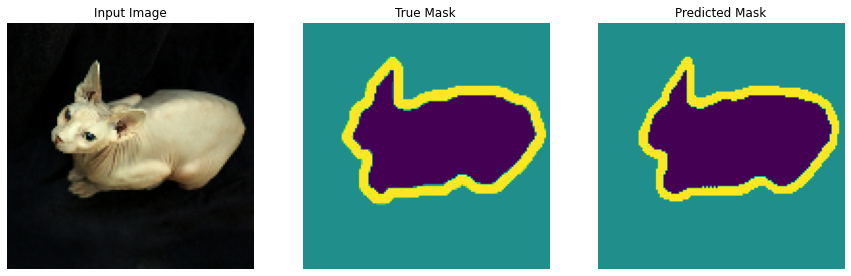


Sample Prediction after epoch 10

920/920 [==============================] - 54s 59ms/step - loss: 0.1857 - accuracy: 0.9199 - val_loss: 0.3211 - val_accuracy: 0.8852
Epoch 11/20
1/1 [==============================] - 0s 22ms/step


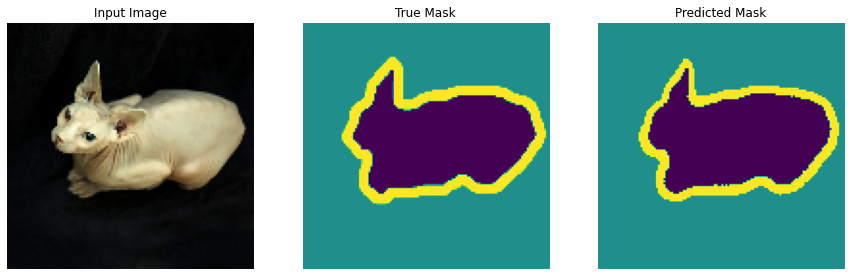


Sample Prediction after epoch 11

920/920 [==============================] - 54s 59ms/step - loss: 0.1740 - accuracy: 0.9239 - val_loss: 0.3226 - val_accuracy: 0.8844
Epoch 12/20
1/1 [==============================] - 0s 23ms/step


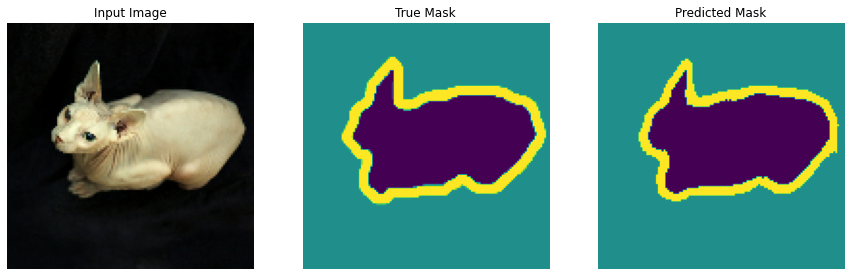


Sample Prediction after epoch 12

920/920 [==============================] - 54s 59ms/step - loss: 0.1655 - accuracy: 0.9270 - val_loss: 0.3446 - val_accuracy: 0.8847
Epoch 13/20
1/1 [==============================] - 0s 26ms/step


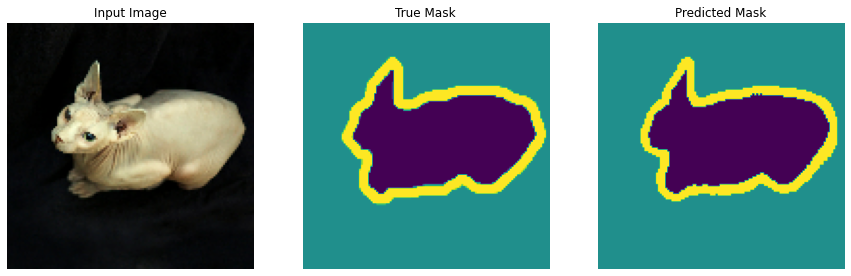


Sample Prediction after epoch 13

920/920 [==============================] - 54s 59ms/step - loss: 0.1688 - accuracy: 0.9262 - val_loss: 0.3635 - val_accuracy: 0.8831
Epoch 14/20
1/1 [==============================] - 0s 32ms/step


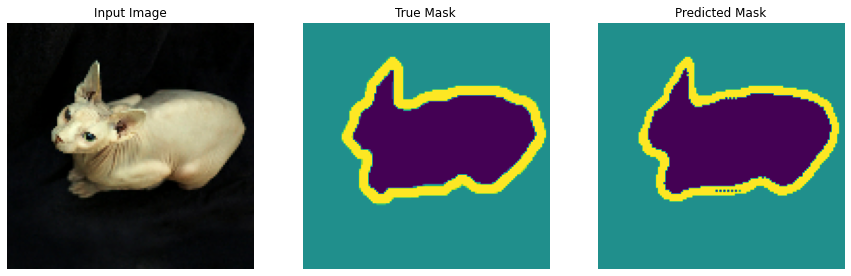


Sample Prediction after epoch 14

920/920 [==============================] - 54s 59ms/step - loss: 0.1544 - accuracy: 0.9310 - val_loss: 0.3868 - val_accuracy: 0.8851
Epoch 15/20
1/1 [==============================] - 0s 22ms/step


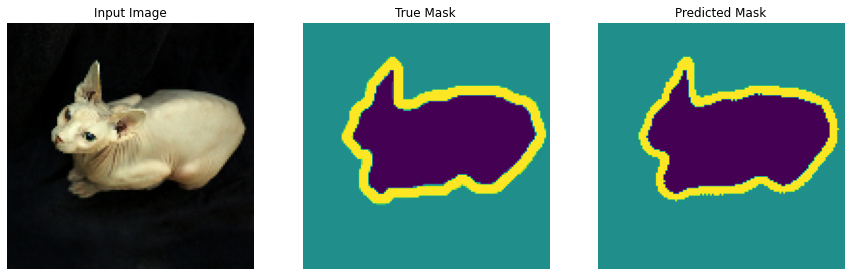


Sample Prediction after epoch 15

920/920 [==============================] - 54s 59ms/step - loss: 0.1534 - accuracy: 0.9313 - val_loss: 0.3813 - val_accuracy: 0.8862
Epoch 16/20
1/1 [==============================] - 0s 21ms/step


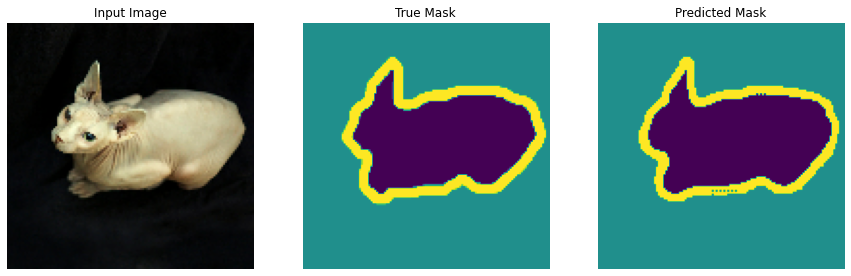


Sample Prediction after epoch 16

920/920 [==============================] - 54s 59ms/step - loss: 0.1476 - accuracy: 0.9335 - val_loss: 0.3829 - val_accuracy: 0.8842
Epoch 17/20
1/1 [==============================] - 0s 22ms/step


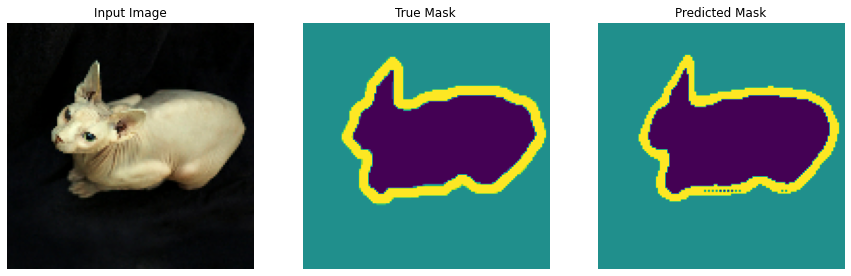


Sample Prediction after epoch 17

920/920 [==============================] - 54s 59ms/step - loss: 0.1460 - accuracy: 0.9340 - val_loss: 0.3729 - val_accuracy: 0.8855
Epoch 18/20
1/1 [==============================] - 0s 38ms/step


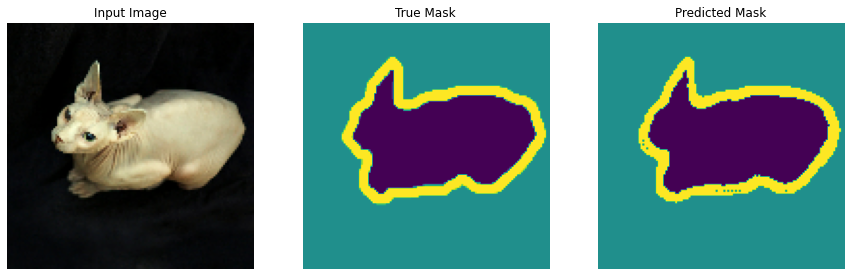


Sample Prediction after epoch 18

920/920 [==============================] - 55s 60ms/step - loss: 0.1386 - accuracy: 0.9368 - val_loss: 0.3484 - val_accuracy: 0.8861
Epoch 19/20
1/1 [==============================] - 0s 24ms/step


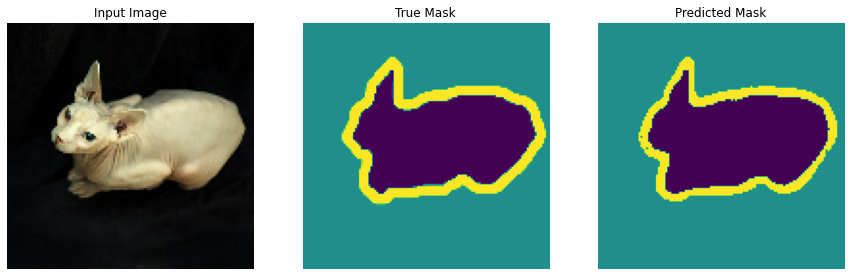


Sample Prediction after epoch 19

920/920 [==============================] - 55s 60ms/step - loss: 0.1396 - accuracy: 0.9367 - val_loss: 0.3837 - val_accuracy: 0.8821
Epoch 20/20
1/1 [==============================] - 0s 25ms/step


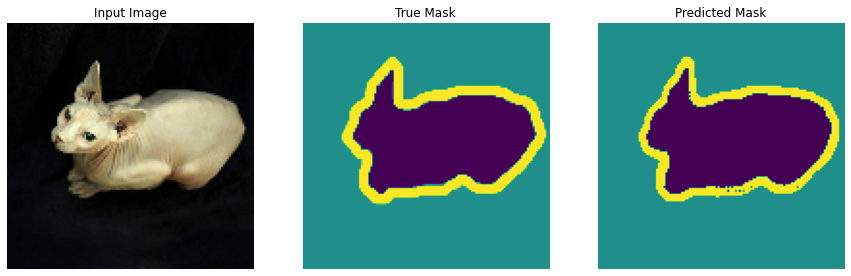


Sample Prediction after epoch 20

920/920 [==============================] - 54s 59ms/step - loss: 0.1313 - accuracy: 0.9396 - val_loss: 0.4315 - val_accuracy: 0.8856


In [21]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

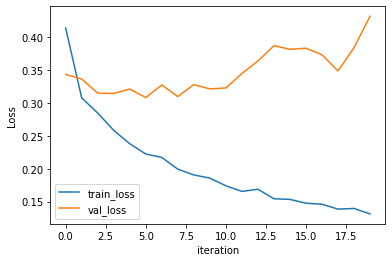

In [22]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['loss'], label = "train_loss")
plt.plot(model_history.history['val_loss'], label = "val_loss")
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()




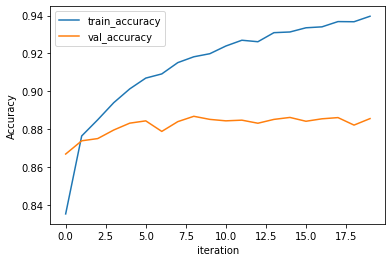

In [23]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'], label = "train_accuracy")
plt.plot(model_history.history['val_accuracy'], label = "val_accuracy")
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.legend()

1/1 [==============================] - 0s 26ms/step


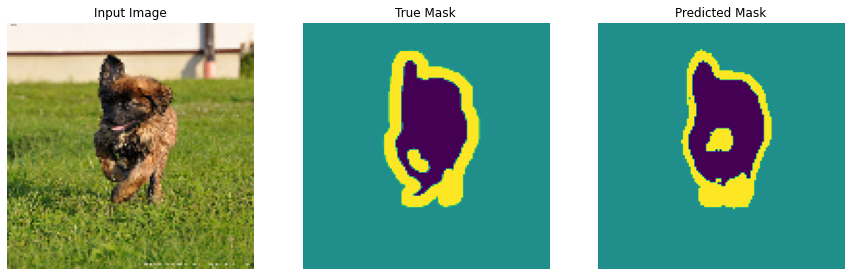

1/1 [==============================] - 0s 26ms/step


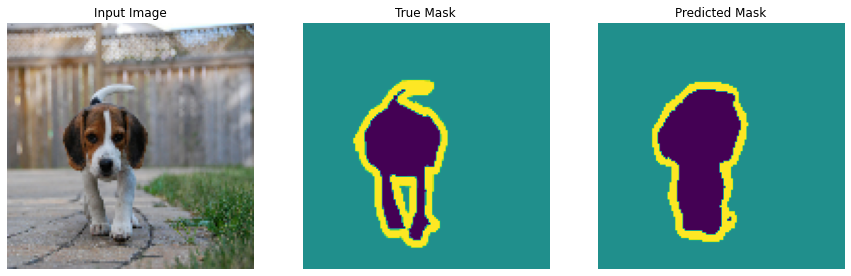

1/1 [==============================] - 0s 23ms/step


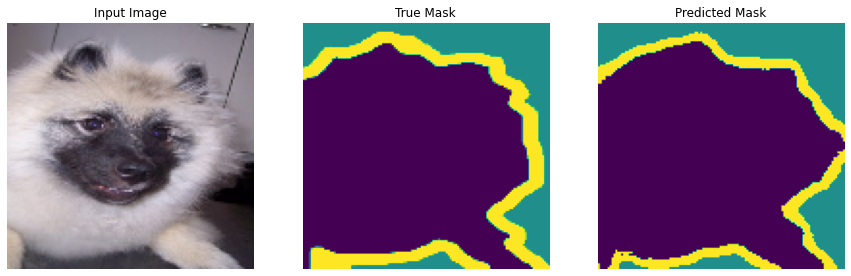

1/1 [==============================] - 0s 26ms/step


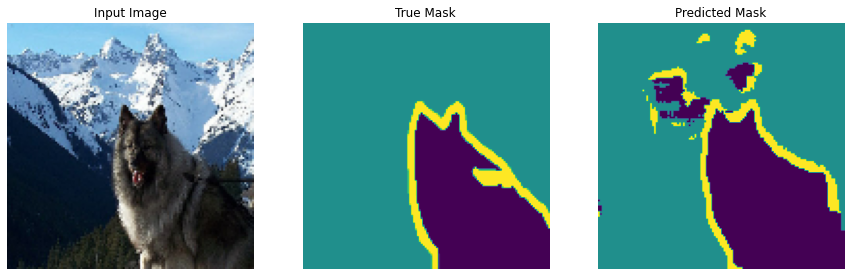

1/1 [==============================] - 0s 25ms/step


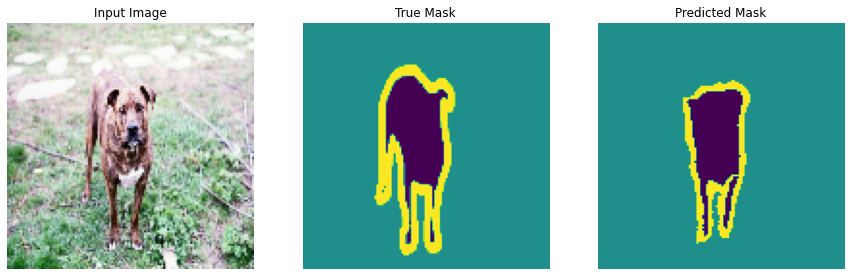

1/1 [==============================] - 0s 24ms/step


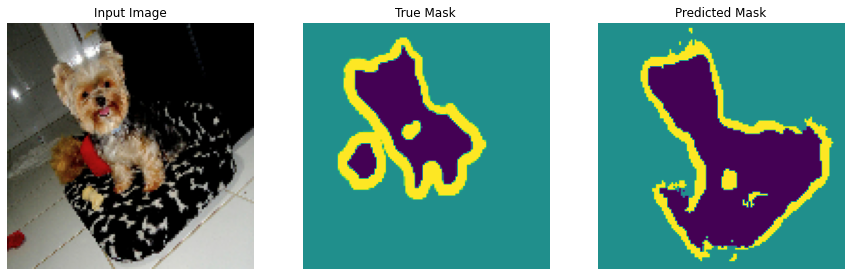

1/1 [==============================] - 0s 23ms/step


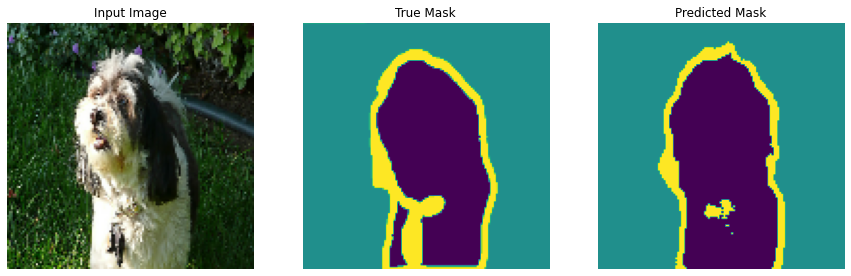

1/1 [==============================] - 0s 35ms/step


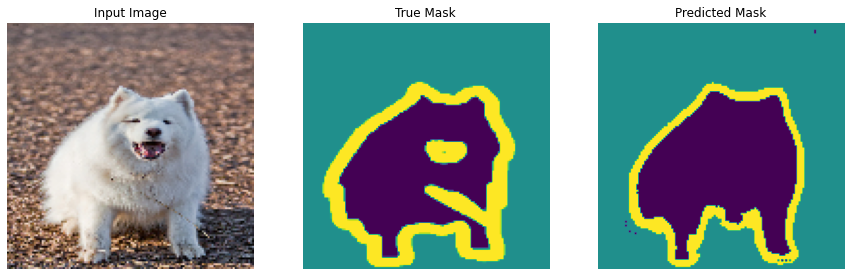

1/1 [==============================] - 0s 24ms/step


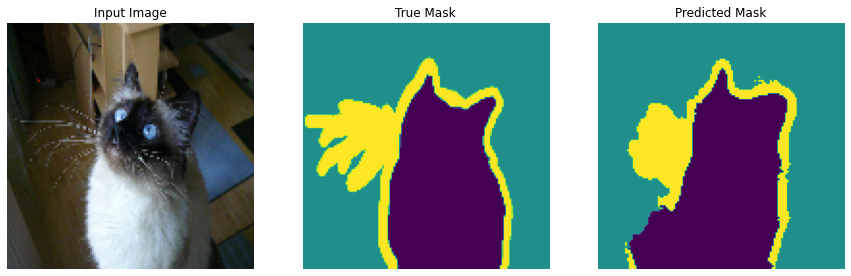

1/1 [==============================] - 0s 23ms/step


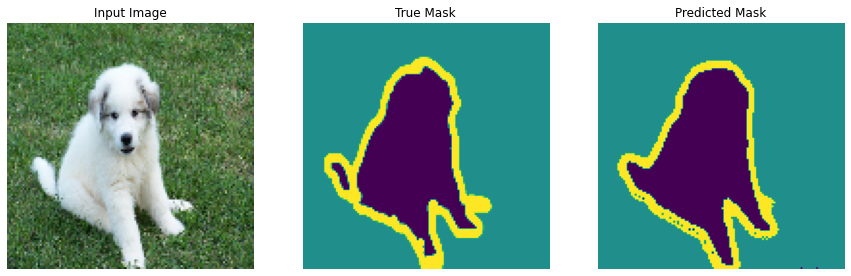

1/1 [==============================] - 0s 29ms/step


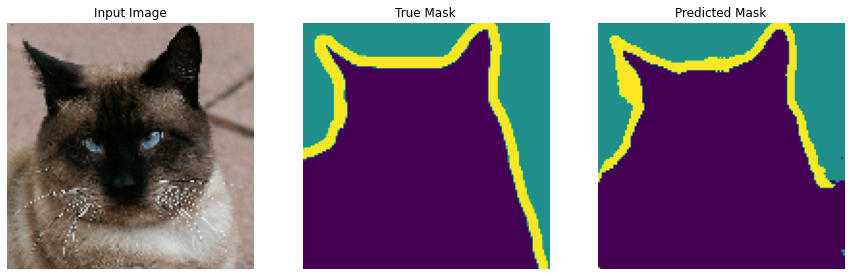

1/1 [==============================] - 0s 32ms/step


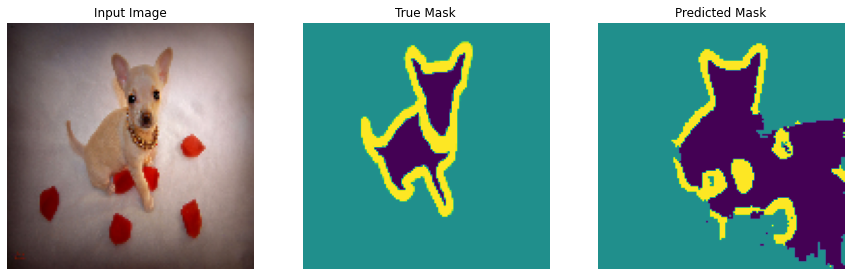

1/1 [==============================] - 0s 28ms/step


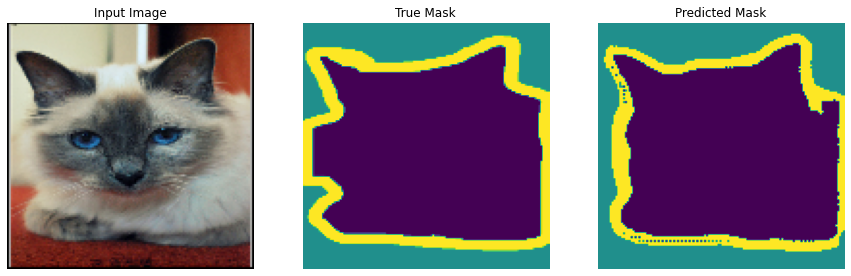

1/1 [==============================] - 0s 28ms/step


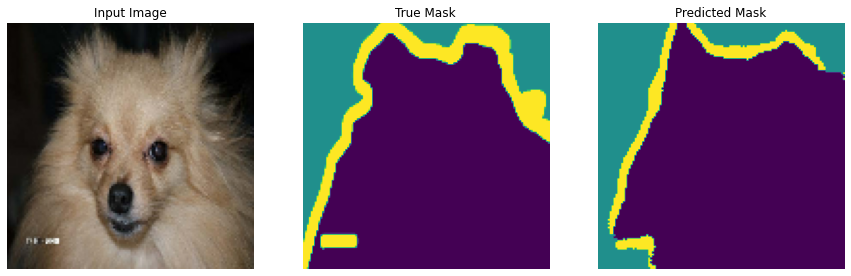

1/1 [==============================] - 0s 52ms/step


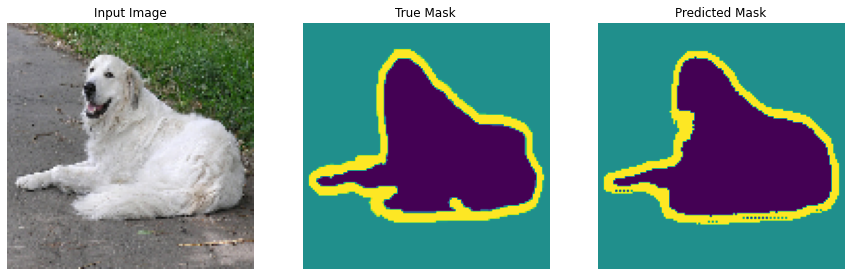

In [24]:
show_predictions(test_dataset, 15)